<a href="https://colab.research.google.com/github/jodoldar/PracticasRNA/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install keras
!pip3 install graphviz

In [0]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import GaussianNoise as GN
from keras.layers import Reshape
from keras.layers.normalization import BatchNormalization as BN

from keras.optimizers import SGD
import keras.backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler as LRS
from keras.callbacks import ReduceLROnPlateau

from keras.utils.vis_utils import plot_model

In [0]:
batch_size = 128
epochs = 75
num_classes=10

In [0]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [0]:
# Mandatory to use ImageDataGenerator, it expects 4D Tensors
x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.reshape(10000,28,28,1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize [0..255]-->[0..1]
x_train /= 255
x_test /= 255

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 train samples
10000 test samples


In [0]:
sgd=SGD(lr=0.5, decay=0.0, momentum=0.0)

In [0]:
def scheduler(epoch):
  if epoch < 5:
    return .5
  elif epoch < 25:
    return .1
  elif epoch < 50:
    return 0.01
  else:
    return 0.001

set_lr = LRS(scheduler)

In [0]:
## Model, note the reshape
model = Sequential()

model.add(Reshape(target_shape=(784,), input_shape=(28,28,1)))
model.add(Dense(1024, activation='relu'))
model.add(BN())
model.add(GN(0.25))
model.add(Activation('relu'))

model.add(GN(0.25))
model.add(Dense(2048, activation='relu'))


model.add(Dropout(0.25))
model.add(GN(0.15))
model.add(Dense(64, activation='relu'))

model.add(BN())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.summary()
##
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
gaussian_noise_4 (GaussianNo (None, 1024)              0         
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
_________________________________________________________________
gaussian_noise_5 (GaussianNo (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              2099200   
__________

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3,
                                           verbose=1, factor=0.5,
                                           min_lr=0.0001)

In [0]:
## Data Augmentation with an ImageGenerator
datagen = ImageDataGenerator(
    rotation_range=1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False)

In [0]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=sgd,
              metrics=['accuracy'])

In [0]:
datagen.fit(x_train)
history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=x_train.shape[0] // batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[learning_rate_reduction],
                            verbose=1)


score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/75
468/468 [==============================] - 21s 45ms/step - loss: 0.3839 - acc: 0.8797 - val_loss: 0.1305 - val_acc: 0.9585
Epoch 2/75
468/468 [==============================] - 20s 43ms/step - loss: 0.2013 - acc: 0.9383 - val_loss: 0.0869 - val_acc: 0.9723
Epoch 3/75
468/468 [==============================] - 20s 43ms/step - loss: 0.1648 - acc: 0.9503 - val_loss: 0.0954 - val_acc: 0.9721
Epoch 4/75
468/468 [==============================] - 20s 42ms/step - loss: 0.1410 - acc: 0.9576 - val_loss: 0.0685 - val_acc: 0.9788
Epoch 5/75
468/468 [==============================] - 20s 42ms/step - loss: 0.1310 - acc: 0.9599 - val_loss: 0.0601 - val_acc: 0.9812
Epoch 6/75
468/468 [==============================] - 20s 42ms/step - loss: 0.1175 - acc: 0.9640 - val_loss: 0.0627 - val_acc: 0.9778
Epoch 7/75
468/468 [==============================] - 20s 42ms/step - loss: 0.1143 - acc: 0.9655 - val_loss: 0.0617 - val_acc: 0.9802
Epoch 8/75
468/468 [==============================] - 19s 42ms

In [0]:
import matplotlib.pyplot as plt #for plotting
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

In [0]:
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

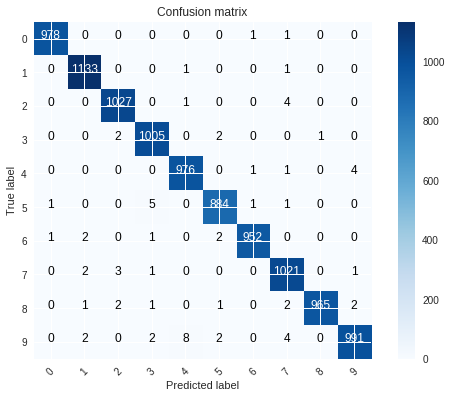

In [0]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


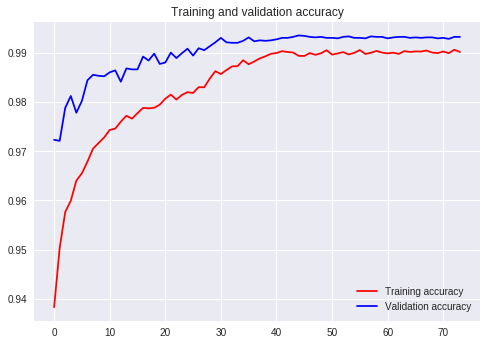

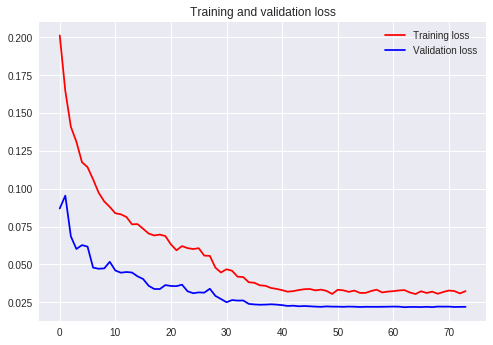

In [0]:
print(history.history.keys())
accuracy = history.history['acc'][1:]
val_accuracy = history.history['val_acc'][1:]
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()